
# 03 MLP + Stratified K-Fold

MultiLayer Perceptron is a feed forward neural network with an input layer, one or more hidden layers, and an output layer. Each layer applies an affine transform (weights and biases) by a nonlinear activation (sigmoid, ReLU, or tanh). It computes the outputs by forward propagation and learns the parameters by backpropagation plus an optimizer to minimize a loss such as cross entropy. 

![image.png](attachment:a6cacfba-a41e-4272-b389-d928176621e8.png)

MLP is expected to perform exceptionally better than the single perceptron due to the non linear activations.

Self-contained notebook to:
- load `data/processed/train.csv` and `test.csv`,
- train an MLP (with StandardScaler) and do **Stratified K-Fold** cross-validation,
- evaluate on the test set (F2, AUPRC, AUROC, confusion matrix),
- save `models/model_mlp.joblib` and `models/meta_mlp.json`.

In [12]:
# Imports
import os, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, fbeta_score, average_precision_score, roc_auc_score, ConfusionMatrixDisplay, classification_report

# Paths
DATA_PROCESSED="data/processed"
MODELS_DIR="models"
DEFAULT_THR=0.50
POS_LABEL=1

Path(MODELS_DIR).mkdir(parents=True, exist_ok=True)
assert (
    Path(DATA_PROCESSED, "train.csv").exists()
    and Path(DATA_PROCESSED, "test.csv").exists()
), "Run your 01 notebook to create data/processed/train.csv and test.csv first."

In [13]:
#Load processed split
train = pd.read_csv(Path(DATA_PROCESSED, "train.csv"))
test  = pd.read_csv(Path(DATA_PROCESSED, "test.csv"))

TARGET = "diagnosis"

X_tr = train.drop(columns=[TARGET])
y_tr = train[TARGET]
X_te = test.drop(columns=[TARGET])
y_te = test[TARGET]

print("Train:", X_tr.shape, "Test:", X_te.shape)
print("Class counts (train):", np.bincount(y_tr))
print("Class counts (test) :", np.bincount(y_te))


Train: (455, 30) Test: (114, 30)
Class counts (train): [285 170]
Class counts (test) : [72 42]


In [14]:
# MLP + Stratified K-Fold CV
pipe_mlp = imb_make_pipeline(
    StandardScaler(), MLPClassifier(hidden_layer_sizes=(64,), activation="relu", solver="lbfgs", alpha=1e-4, random_state=42)
)

In [15]:
# Modest grid for quick CV; scoring by PR-AUC (good for imbalance)
param_grid = {
    "mlpclassifier__hidden_layer_sizes": [(32,), (64,), (64,32)],
    "mlpclassifier__alpha": [1e-4, 1e-3, 1e-2],
    "mlpclassifier__learning_rate_init": [1e-3, 3e-4],
    "mlpclassifier__max_iter": [1000, 2000]
}

In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"pr_auc": "average_precision", "roc_auc": "roc_auc"}

In [17]:
gs = GridSearchCV(pipe_mlp, param_grid, scoring=scoring, refit="pr_auc", cv=cv, n_jobs=-1, verbose=0, error_score="raise")

In [18]:
gs.fit(X_tr, y_tr)

,estimator,Pipeline(step...er='lbfgs'))])
,param_grid,"{'mlpclassifier__alpha': [0.0001, 0.001, ...], 'mlpclassifier__hidden_layer_sizes': [(32,), (64,), ...], 'mlpclassifier__learning_rate_init': [0.001, 0.0003], 'mlpclassifier__max_iter': [1000, 2000]}"
,scoring,"{'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}"
,n_jobs,-1
,refit,'pr_auc'
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,'raise'
,return_train_score,False
,copy,True


In [19]:
print("Best params:", gs.best_params_)
print("Best CV PR-AUC:", round(gs.best_score_, 4))

# Grab the best estimator
mlp_best = gs.best_estimator_

Best params: {'mlpclassifier__alpha': 0.01, 'mlpclassifier__hidden_layer_sizes': (64,), 'mlpclassifier__learning_rate_init': 0.001, 'mlpclassifier__max_iter': 1000}
Best CV PR-AUC: 0.9933


In [20]:
# --- Test evaluation at default 0.50 threshold
proba_te = mlp_best.predict_proba(X_te)[:, 1]
print("\nClassification report:\n", classification_report(y_te, (proba_te >= DEFAULT_THR).astype(int), zero_division=0))


Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



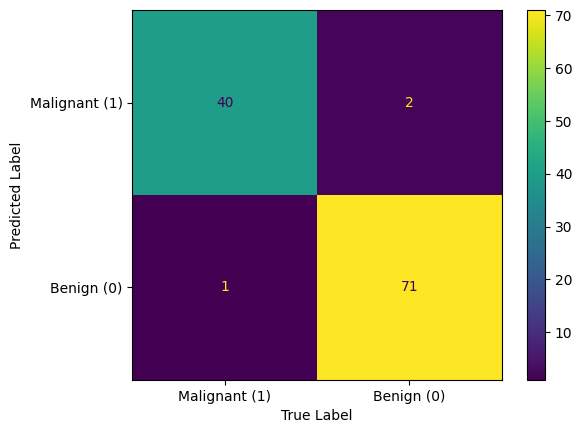

In [21]:
y_pred = mlp_best.predict(X_te)
ConfusionMatrixDisplay.from_predictions(
    y_te, y_pred, labels=[1,0], display_labels=["Malignant (1)","Benign (0)"]
)
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.show()

Our model does a strong job of spotting cancer cancer cases, correctly identifying about 9 out of 10 of them. Only a small handful of healthy cases get flagged by mistake. The trade-off is that it still misses about 1 in 10 cancers which it's not reliable enough to stand alone as the only tool. 

The value:
It can highlight high risk cases for doctors to review quickly and act as a second set of eyes to reduce the chance something important is overlooked. 

In [22]:

# --- Save artifacts (model + meta)
import joblib

model_path = Path(MODELS_DIR, "model_mlp.joblib")
meta_path  = Path(MODELS_DIR, "meta_mlp.json")

joblib.dump(mlp_best, model_path)
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump({
        "features": list(X_tr.columns),
        "pos_label": 1,
        "threshold": DEFAULT_THR,
        "target": TARGET,
        "notes": "MLP with StandardScaler; CV refit by PR-AUC"
    }, f, indent=2)

print(f"Saved {model_path} and {meta_path}")


Saved models\model_mlp.joblib and models\meta_mlp.json
